<a href="https://colab.research.google.com/github/daphnecor/Computational_neuroscience/blob/main/00_intro_to_successor_representations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Introduction

---

The purpose of this notebook is to gain intuition on successor representations and explore whether they can be useful in multi-agent (partially observable) settings.

In short, the successor representation (SR) is, like the value function, a **_cumulant_**. It tells us something about our MDP summarized across time.
- the value function is a cumulant of the **discounted reward**:
\begin{align}
    V^\pi(s) = \mathbb{E}\left[ \sum_{t=0}^H \gamma^t R_{t+1} \mid s_0=s \right]
\end{align}

- the successor representation (SR) is a cumulant of the **discounted occupancy**:
\begin{align}
    M^{\pi}(s,  ̃s \,) &= \sum_{a} \pi(a \mid s) \sum_{s'} p(s' \mid s, a) \left[ \mathbb{I}[s' = ̃s ] + \gamma M^\pi(s', ̃s) \right] \\
                      &= \mathbb{E} \left[ \mathbb{I}[s' = ̃s] + \gamma M^\pi (s, ̃s) \right]
\end{align}
    - In words, it tells us: If I start in state $s$, what are the odds that I end up in state $\tilde \ s$ ?

## 2. Learning to navigate in a simple grid world

___

As an exercise, we reproduce Figure 2 from the paper [Predictive representations: building blocks of intelligence](https://arxiv.org/abs/2402.06590) by Carvalho et al., 2024.

The Figure displays the value function and successor representation of a simple, deterministic grid world. In line with the paper, we make the following assumptions:
- Reward function:
\begin{align}
    R(s, a, s') =
    \begin{cases}
    1, \quad \text{if s is the goal state} \\
    -0.1, \quad \text{otherwise}
    \end{cases}
\end{align}

- We are interacting with a finite horizon MDP, with $H=100$.
- We always start in the same state.
- We always have the same goal state.
- If you walk against a wall or an obstacle, you stay in the same state.


In [1]:
# Dependencies
import gym
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import warnings

from IPython.display import display, Markdown, Latex, HTML
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'svg'
sns.set("notebook", font_scale=1.)
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})

### 2.1 Make environment

In [2]:
class SmallGridWorld(gym.Env):

    def __init__(self, grid_size=5):
        self.grid_size = grid_size
        self.time = 0
        self.horizon = 100

        self.num_states = self.grid_size ** 2

        # Define state and state space
        self.action_space = gym.spaces.Discrete(4)
        self.action_idx_to_name = {
            0: 'up',
            1: 'down',
            2: 'left',
            3: 'right'
        }
        self.observation_space = observation_space = gym.spaces.Tuple((gym.spaces.Discrete(5), gym.spaces.Discrete(5)))
        self.states_set = list(itertools.product(range(self.grid_size), range(self.grid_size)))
        self.grid_pos_to_state = {
            str((i, j)): self.pos_to_state(i, j)
            for i, j in self.states_set
        }
        self.start_state = random.choice(self.states_set)
        self.goal_state = (grid_size-1, grid_size-1) # TODO(dc): Set of random, non-start state in the grid
        self.forbidden_states = []

        # Make a grid
        self.df_map = pd.DataFrame(
            np.zeros((self.grid_size, self.grid_size))
        )

        # Create environment
        self.format_map()

    def reset(self):
        """Reset the environment to its initial state."""
        self.time = 0
        state = random.choice(self.states_set)
        self.format_map()
        return state

    def step(self, state, action):
        """Take a step in the environment.

        Args:
            state (tuple): The current state of the environment.
            action (int): The action to take (0-3).
        """
        if action == 0:  # Move up
            next_state = (max(0, state[0] - 1), state[1])
        elif action == 1:  # Move down
            next_state = (min(self.grid_size - 1, state[0] + 1), state[1])
        elif action == 2:  # Move left
            next_state = (state[0], max(0, state[1] - 1))
        elif action == 3:  # Move right
            next_state = (state[0], min(self.grid_size - 1, state[1] + 1))

        # Reward function
        reward = self.reward(next_state)

        # Check if the goal state has been reached
        done = (next_state == self.goal_state)

        self.time += 1

        return next_state, reward, done

    def reward(self, next_state):
        """The reward function: +1 if the goal state is reached, -0.1 otherwise."""
        return 1 if (next_state == self.goal_state) else -0.1

    def pos_to_state(self, x, y):
        """Convert 2D grid coordinates to 1D state index."""
        return x * self.grid_size + y

    def format_map(self):
        self.df_env_text = self.df_map.copy()
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if (i, j) in self.forbidden_states:
                    self.df_env_text.iloc[i, j] = r'$x$'
                if (i, j) == self.goal_state:
                    self.df_env_text.iloc[i, j] = r'$G$'
                    self.df_map.iloc[i, j] = 1
                if (i, j) != self.goal_state:
                    self.df_map.iloc[i, j] = -0.1
                    self.df_env_text.iloc[i, j] = r' '
                if (i, j) == self.start_state:
                    self.df_env_text.iloc[i, j] = r'$S$'

    def render(self):
        """Visualize the environment."""
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        ax.set_title(f"Grid world | t = {self.time}")
        df_env_text = self.df_env_text.copy()
        sns.heatmap(self.df_map, annot=df_env_text, cmap='coolwarm', fmt="", ax=ax)
        plt.show();

In [3]:
env = SmallGridWorld()

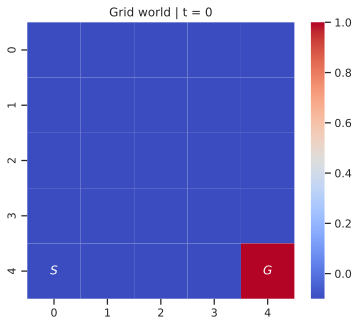

In [4]:
env.render()

### 2.2 Create the transition matrix from rollouts

We step through the environment and obtain the transition "probabilities" that way.

In [5]:
num_rollouts = 10_000

# T = (grid_size^2, 4, grid_size^2)
transition_probs = np.zeros((env.num_states, env.action_space.n, env.num_states))

for rollout in range(num_rollouts):

    state = env.reset()
    state_flat = env.pos_to_state(state[0], state[1])

    for t in range(env.horizon):

        # Sample a random action (0-3)
        action = env.action_space.sample()

        # TAKE A STEP
        next_state, reward, done = env.step(state, action)

        next_state_flat = env.pos_to_state(next_state[0], next_state[1])

        # ADD TO TRANSITION MATRIX
        transition_probs[state_flat, action, next_state_flat] += 1

        state = next_state
        state_flat = env.pos_to_state(state[0], state[1])

# Normalize the transition probabilities
for s in range(env.num_states):
    for a in range(env.action_space.n):
        total_transitions = np.sum(transition_probs[s, a])
        if total_transitions > 0:
            transition_probs[s, a] /= total_transitions

### 2.3 Inspect the transition matrix

We can aggregate the transition probabilities along the action dimension to view how likely it is to transition
 from state $s$ to state $s'$:

\begin{align}
    p(s' \mid s) = \sum_{a \in A} p(s' \mid s, a)
\end{align}

Since our environment is deterministic, all entries in the matrix should be either one, zero, or two for the corners in the grid (since in that case two actions result in the same state).

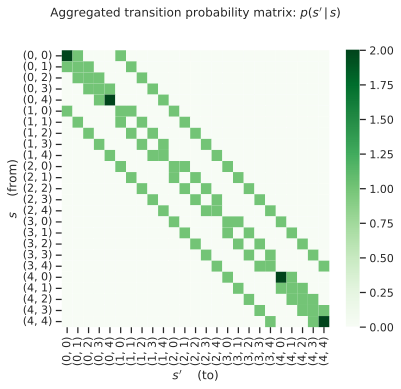

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(transition_probs.sum(axis=(1)), xticklabels=env.grid_pos_to_state.keys(), yticklabels=env.grid_pos_to_state.keys(), cmap='Greens', fmt='.2f', ax=ax)
ax.set_title(r"Aggregated transition probability matrix: $p( s' \, |\, s)$", y=1.10);
ax.set_ylabel(r'$s \quad$ (from)')
ax.set_xlabel(r"$s' \quad$ (to)");

### 2.4 Value iteration for a random policy

Now, how do we obtain the value function for a random policy in the grid world? Since we "know" the transition probabilities, we can use value iteration to iteratively learn an accurate value function $V^\pi(s)$ using the Bellman equation for the $v_\pi$:

\begin{align}
    V_{k+1}^\pi(s) = \max_a \sum_{s'} p(s' \mid s, a) \left[ R(s') + \gamma V^\pi_k (s') \right]
\end{align}


---

> Note: Since we explicitly use the transition probabilities, this is considered a model-based approach.

----

In [7]:
def value_iteration(env, theta=1e-2, gamma=0.98, max_iters=100):

    # Initialize the value function for all states: V(s) = 0
    value_function = pd.DataFrame(np.zeros((env.grid_size, env.grid_size)))
    errors = []

    state = env.reset()

    iter_ = 0
    while iter_ < max_iters:

        delta = 0

        # LOOP OVER ALL STATES
        for s_i, s_j in env.states_set:

            value_s_old = value_function.iloc[s_i, s_j]

            # COMPUTE EXPECTED RETURN FOR EACH (S, A) PAIR
            act_values = np.zeros(env.action_space.n)

            for act in range(env.action_space.n):
                action_value = 0

                for s_i_next, s_j_next in env.states_set:

                    p_s_a_s_next = transition_probs[
                        env.pos_to_state(s_i, s_j),
                        act,
                        env.pos_to_state(s_i_next, s_j_next)
                    ]

                    reward_s_next = env.reward((s_i_next, s_j_next))

                    action_value += p_s_a_s_next * (reward_s_next + gamma * value_function.iloc[s_i_next, s_j_next])

                act_values[act] = action_value

            # Update the value of state s using the best thing we can do
            value_function.iloc[s_i, s_j] = np.max(act_values)

            # Check for convergence
            delta = max(delta, np.abs(value_s_old - value_function.iloc[s_i, s_j]))

            errors.append(delta)
            if delta < theta:
                break

        iter_ += 1

    return value_function, env, iter_, errors

# RUN VALUE ITERATION
value_function, env, iter_, errors = value_iteration(env, max_iters=500)

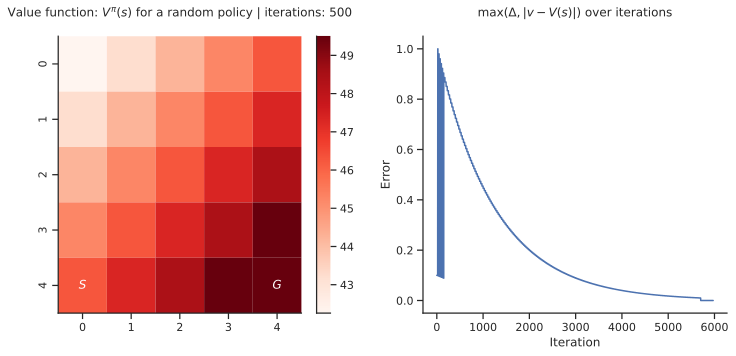

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(data=value_function, annot=env.df_env_text, cmap='Reds', fmt="", ax=axs[0])
axs[0].set_title(f"Value function: $V^\pi(s)$ for a random policy | iterations: {iter_}", y=1.05);
axs[0].set_ylabel(r'')
axs[0].set_xlabel(r'')

axs[1].set_title(r"$\max(\Delta, |v - V(s)|)$ over iterations", y=1.05)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel("Error")
sns.lineplot(errors, ax=axs[1])
sns.despine()

### 2.5 Succesor representation iteration for a random policy

We computed the value function for a random policy $\pi$. How can we do the same for the successor representation, the discounted occupancy? Recall that the successor representation is defined as:

\begin{align}
    M^\pi (s, \tilde{\, s \, }) = \mathbb{E} \left[ \sum_{t = 0}^H \gamma^t \mathbb{I}[s_{t + 1} = \tilde{\, s \, }] \mid s_0 = s \right]
\end{align}

where $\tilde{\, s \, }$ denotes a future state and $\mathbb{I}(.)$ is an indicator function. In words, $M^\pi (s, \tilde{\, s \, })$ is the expected discounted occupancy of $\tilde{\, s \, }$, given that we start in state $s$.

Well, just like value functions, the occupancy also obeys a Bellman equation, that is, it is defined recursively:

\begin{align}
    M^\pi (s, \tilde{\, s \, })
    &= \sum_{a} \pi (a \mid s) \sum_{s'} p(s' \mid s, a) \left[ \mathbb{I}[s' = \tilde{\, s \, }] + \gamma M(s', \tilde{\, s \, }) \right] \\
    &= \mathbb{E} \left[ \mathbb{I}[s' = \tilde{\, s \, }] + \gamma M^{\pi} (s', \tilde{\, s \, }) \right]
\end{align}

In [39]:
def random_policy(state):
    """Define a random uniform policy.

    Args:
        state (tuple): The current state of the environment.
    Returns:
        int: The action to take (0-3).
        float: The probability of taking the action.
    """
    return np.random.choice(env.action_space.n, size=1), 1 / env.action_space.n

def occupancy_iteration(policy, eta=0.01, gamma=0.99, max_iters=5):

    # Initialize M(s, \tilde{s})
    M = pd.DataFrame(np.zeros((env.num_states, env.num_states)))

    iter_ = 0
    while iter_ < max_iters:

        # LOOP OVER ALL STATES
        for s_i_tilde, s_j_tilde in env.states_set:

            state_tilde = env.pos_to_state(s_i_tilde, s_j_tilde)

            # LOOP OVER ALL STATES
            for s_i, s_j in env.states_set:

                s_tilde_value = 0

                for act in range(env.action_space.n):

                    # Random policy
                    _, pi_a_given_s = policy(s_i)

                    for s_i_next, s_j_next in env.states_set:

                        p_s_next_given_s_a = transition_probs[
                            env.pos_to_state(s_i, s_j),
                            act,
                            env.pos_to_state(s_i_next, s_j_next)
                        ]

                        # COMPUTE EXPECTED discounted occupancy of state ~s
                        indic = 1 if (s_i_next, s_j_next) == (s_i_tilde, s_j_tilde) else 0

                        # Convert grid positions to integer states
                        state = env.pos_to_state(s_i, s_j)
                        state_next = env.pos_to_state(s_i_next, s_j_next)

                        s_tilde_value += pi_a_given_s * p_s_next_given_s_a * (indic + gamma * M.iloc[state_next, state_tilde])

                # Update M
                M.iloc[state, state_tilde] = s_tilde_value

                # Check for convergence
                #delta = max(delta, np.abs(M_s_old - value_function.iloc[s_i, s_j]))


        iter_ += 1

    return M

In [40]:
SR = occupancy_iteration(
    policy=random_policy
)

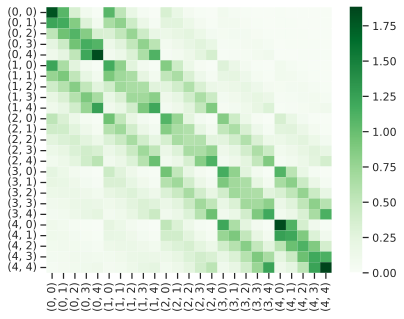

In [43]:
sns.heatmap(SR, xticklabels=env.grid_pos_to_state.keys(), yticklabels=env.grid_pos_to_state.keys(), cmap='Greens');

### Next steps:

- [ ] Define an agent and learn the SR from rollouts (experience)



Notes: We can use the following update rule to obtain $M$:

\begin{align}
    M^\pi_{k + 1} (s, \tilde{\, s \, }) = M^\pi_{k} + \eta \cdot \left[ \mathbb{I}[s' =  \tilde{\, s \, }] + \gamma M_k^\pi (s', \tilde{\, s \, }) - M^\pi_k(s, \tilde{\, s \, }) \right]
\end{align}

